# scNym Cell Type Prediction Tutorial

In [1]:
import scanpy.api as sc
import os
import os.path as osp
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import scnym
from scnym.predict import Predicter

## Download Example Data

In [4]:
%%bash
mkdir ../downloads
# wget -nv https://storage.googleapis.com/calico-website-mca-storage/20190604_tissue_independent_h0256_l1.pkl \
#     -O ../downloads/model_weights.pkl
wget -nv https://storage.googleapis.com/calico-website-mca-storage/20190604_tissue_specific_weights_h0256_l1.tar.gz \
    -O ../downloads/tissue_specific_weights.tar.gz
wget -nv https://storage.googleapis.com/calico-website-mca-storage/20190604_scnym_training_gene_names.txt \
    -O ../downloads/training_gene_names.txt
wget -nv https://storage.googleapis.com/calico-website-mca-storage/20190604_training_metadata.csv \
    -O ../downloads/training_metadata.csv
wget -nv https://storage.googleapis.com/calico-website-mca-storage/microwell_mouse_cell_atlas_lung.h5ad \
    -O ../downloads/mca_lung_reannotated.h5ad

mkdir: cannot create directory ‘../downloads’: File exists
2019-07-18 12:46:35 URL:https://storage.googleapis.com/calico-website-mca-storage/20190604_tissue_specific_weights_h0256_l1.tar.gz [211326981/211326981] -> "../downloads/tissue_specific_weights.tar.gz" [1]
2019-07-18 12:46:36 URL:https://storage.googleapis.com/calico-website-mca-storage/20190604_scnym_training_gene_names.txt [128251/128251] -> "../downloads/training_gene_names.txt" [1]
2019-07-18 12:46:36 URL:https://storage.googleapis.com/calico-website-mca-storage/20190604_training_metadata.csv [5063191/5063191] -> "../downloads/training_metadata.csv" [1]
2019-07-18 12:46:36 URL:https://storage.googleapis.com/calico-website-mca-storage/microwell_mouse_cell_atlas_lung.h5ad [20795497/20795497] -> "../downloads/mca_lung_reannotated.h5ad" [1]


In [5]:
%%bash
cd ../downloads
tar xvf tissue_specific_weights.tar.gz
cd -

tissue_specific_weights/
tissue_specific_weights/Bladder.pkl
tissue_specific_weights/Liver.pkl
tissue_specific_weights/Thymus.pkl
tissue_specific_weights/Kidney.pkl
tissue_specific_weights/Trachea.pkl
tissue_specific_weights/Heart_and_Aorta.pkl
tissue_specific_weights/Mammary_Gland.pkl
tissue_specific_weights/Spleen.pkl
tissue_specific_weights/Tongue.pkl
tissue_specific_weights/Marrow.pkl
tissue_specific_weights/Limb_Muscle.pkl
tissue_specific_weights/Lung.pkl
/home/jacob/src/scnym/notebooks


In [6]:
os.listdir('../downloads/tissue_specific_weights/')

['Thymus.pkl',
 'Kidney.pkl',
 'Limb_Muscle.pkl',
 'Liver.pkl',
 'Spleen.pkl',
 'Tongue.pkl',
 'Trachea.pkl',
 'Marrow.pkl',
 'Bladder.pkl',
 'Mammary_Gland.pkl',
 'Heart_and_Aorta.pkl',
 'Lung.pkl']

## Load Example Data

We'll use lung data from the ["Mouse Cell Atlas"](https://www.ncbi.nlm.nih.gov/pubmed/29474909) that we have manually annotated with cell ontology class labels to demonstrate cell type prediction. Here, we use `scNym` models trained on the *Tabula Muris* 10X data.

In [7]:
adata = sc.read_h5ad(
    '../downloads/mca_lung_reannotated.h5ad')
print('%d cells and %d genes are in the data set.'%adata.shape)

1500 cells and 25133 genes are in the data set.


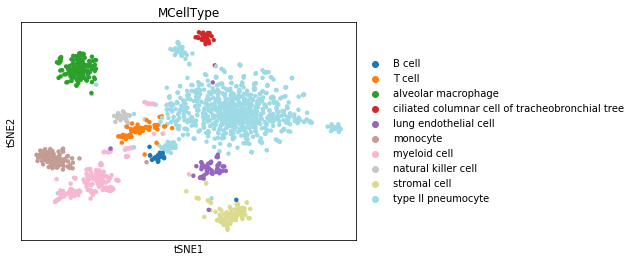

In [8]:
sc.pl.tsne(adata, color='MCellType', palette='tab20') # MCellType are our manual cell type annotations

## Predict Cell Types using an scNym Model

Here we use lung specific weights, available in our tissue specific weights download linked in the README.

In [9]:
model_weights = '../downloads/tissue_specific_weights/Lung.pkl'
training_gene_names = np.loadtxt('../downloads/training_gene_names.txt', dtype='str')
training_metadata = pd.read_csv('../downloads/training_metadata.csv')

print('%d training gene names.'%len(training_gene_names))
print('%d cell types in the training annotation.'%len((training_metadata
                                                       .loc[training_metadata.tissue=='Lung', 'cell_ontology_class']
                                                       .unique())))

18099 training gene names.
13 cell types in the training annotation.


### Prepare input matrix

We first need to generate an expression matrix from our sample data with genes in the same order we used for training. 

scNym has a utility to make this easy. We find that scNym models tend to work well even when only a few thousand genes overlap between data sets.

In [10]:
from scnym.utils import build_classification_matrix

X = build_classification_matrix(X=adata.X.todense(),
                                model_genes=training_gene_names,
                                sample_genes=np.array(adata.var_names))

Building matrix: 18099it [00:21, 856.41it/s]

Found 16117 common genes.


In [11]:
cell_types = sorted(training_metadata.loc[training_metadata.tissue=='Lung','cell_ontology_class'].unique().tolist())
print(cell_types)
P = Predicter(model_weights=model_weights,
              n_genes=len(training_gene_names),
              n_cell_types=len(cell_types),
              labels=cell_types,
              n_hidden=256,
              n_layers=1,
              residual=True)

['B cell', 'T cell', 'alveolar macrophage', 'ciliated columnar cell of tracheobronchial tree', 'classical monocyte', 'leukocyte', 'lung endothelial cell', 'mast cell', 'myeloid cell', 'natural killer cell', 'non-classical monocyte', 'stromal cell', 'type II pneumocyte']


In [12]:
predictions, class_names, probabilities = P.predict(X=X, output='prob')

Finding cell types: 100%|██████████| 1500/1500 [00:04<00:00, 333.86it/s]


In [13]:
# our annotations don't include monocyte subclasses
# so we group them together here
class_names = np.array(class_names)
class_names[class_names=='non-classical monocyte']='monocyte'
class_names[class_names=='classical monocyte']='monocyte'

... storing 'pred_type' as categorical


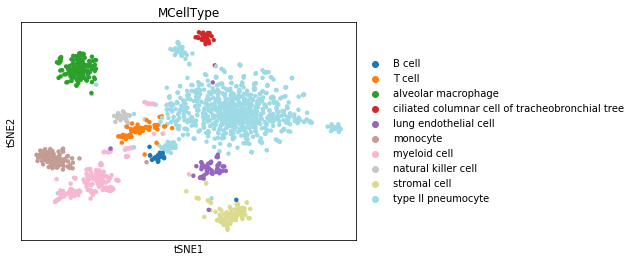

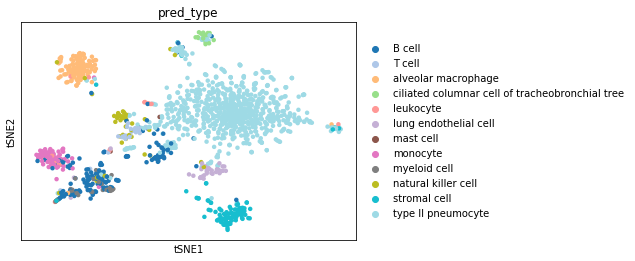

In [14]:
adata.obs['pred_type'] = class_names
sc.pl.tsne(adata, color='MCellType', palette='tab20')
sc.pl.tsne(adata, color='pred_type', palette='tab20')

We see that after a first pass, our model is mostly correct in annotating each cluster.
However, some individual cells within each cluster appear to have the wrong label.

To fix this, we use local neighborhood information to correct some cell type labels.

In [15]:
from scnym.utils import knn_smooth_pred_class

smooth_pred = knn_smooth_pred_class(X=adata.obsm['X_pca'],  # embedding for finding nearest neighbors
                                    pred_class=np.array(adata.obs['pred_type']), # predicted classes
                                    grouping=np.array(adata.obs['louvain']), # cluster partition
                                    k=5, # k-nearest neighbors to consider
                                    )

... storing 'smooth_pred_type' as categorical


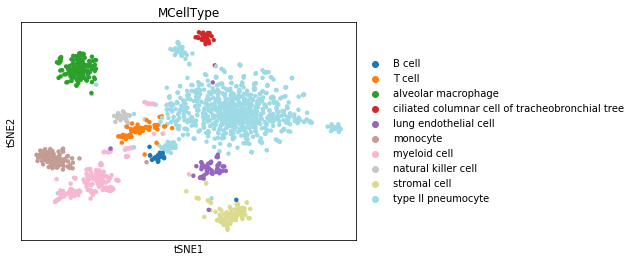

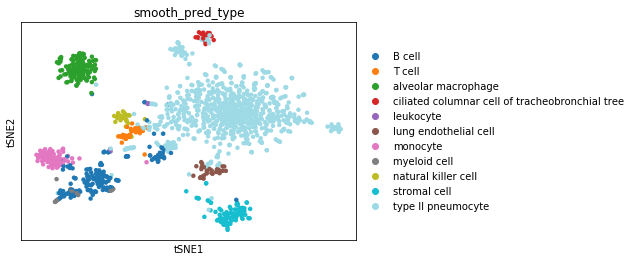

In [16]:
adata.obs['smooth_pred_type'] = smooth_pred
sc.pl.tsne(adata, color='MCellType', palette='tab20')
sc.pl.tsne(adata, color='smooth_pred_type', palette='tab20')

After *k*-NN smoothing, we find that the cell type predictions look mostly correct. The errors we do see are usually confusion between similar cell types in the training data (e.g. myeloid cells and B cells).

Digging further, we find that some of the cells we originally annotated as myeloid might actually be B cells. See the expression pattern of B cell marker [*Cd72*](https://en.wikipedia.org/wiki/CD72) below.

/home/jacob/bin/envs/cbpytorch/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


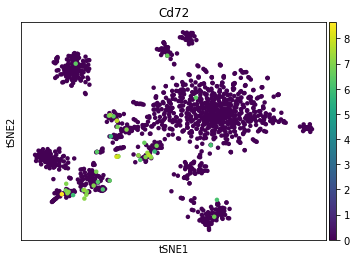

In [17]:
sc.pl.tsne(adata, color='Cd72')

In [18]:
y_true = np.array(adata.obs['MCellType'])
y_pred = np.array(adata.obs['pred_type'])

y_pred_s = np.array(adata.obs['smooth_pred_type'])

acc = np.sum(y_true == y_pred)/len(y_true)
acc_s = np.sum(y_true == y_pred_s)/len(y_true)
print('{:f}% accuracy before smoothing.'.format(acc*100))
print('{:f}% accuracy after smoothing.'.format(acc_s*100))

81.133333% accuracy before smoothing.
84.733333% accuracy after smoothing.


Considering the train and test data are from different experimental platforms on different continents, this seems like a reasonable degree of accuracy for a first pass.

Manual curation can be leveraged to rectify the remaining deficits.